In [1]:
import sys
sys.path.insert(0, '..\\..\\..\\frxas.py')
import glob
import re

import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, fit_report

from frxas import hdf5_io
from frxas import models
from frxas import visualization
from frxas.models import save_fit_report, load_fit_report

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
starts = [[4, 199, 2, 3], [6, 149, 6, 0], [2, 99,3]] # [[0,0,0,0],[0,0,0,0],[0,0,0]]
f1 = hdf5_io.get_all_datasets('..\Model Fitting\July18_20201211_processed', harmonic=1, start_indices=starts)
# f2 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=2, start_indices=starts) 
# f3 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=3, start_indices=starts) 
# f4 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=4, start_indices=starts)

x, data1, ir_avgs, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='adj')
# x, data2, frequencies, gases, sizes, ir_avgs = hdf5_io.unpack_data(f2, kind='adj')
# x, data3, frequencies, gases, sizes, ir_avgs = hdf5_io.unpack_data(f3, kind='adj')
# x, data4, frequencies, gases, sizes, ir_avgs = hdf5_io.unpack_data(f4, kind='adj')

# x0, data0, frequencies0, gases0, sizes0 = hdf5_io.unpack_data(f, kind='adj')

colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data1))
markers = markers * (len(colors) % len(data1))

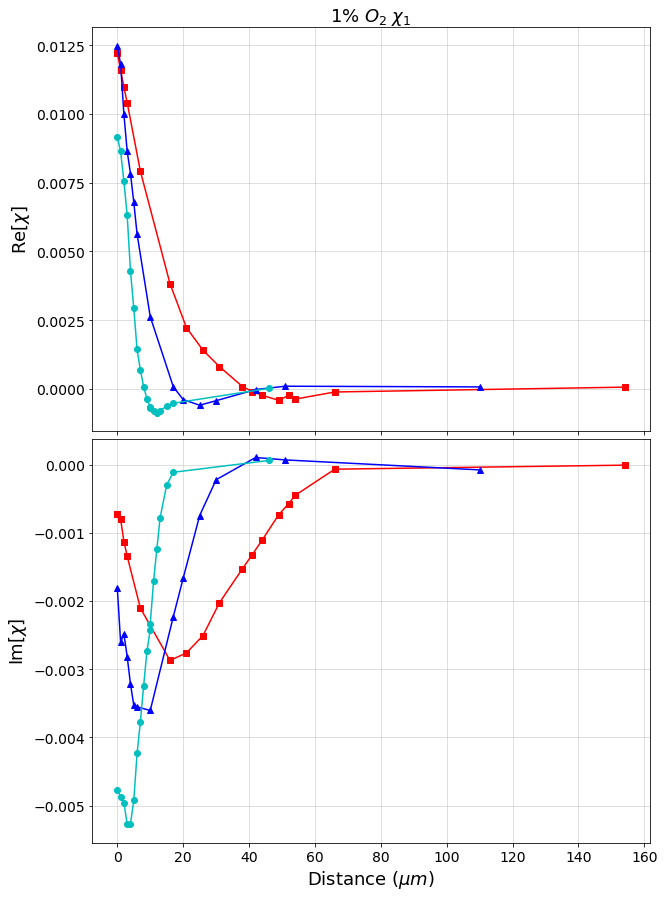

In [3]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
axes[0].set_title('1% $O_2 \; \chi_1$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Chi2 1%O2.png', dpi=400, bbox_inches='tight')

In [4]:
dc_data = [data1[0], data1[4], data1[8]]
dc_x = [x[0], x[4], x[8]]

In [5]:
def chi_dc(x, amp=1, ld=10, gamma=0, base=0):
    chi = amp * (np.exp(-x / ld))/(1 + gamma) + base
    return chi

In [6]:
dc_data_dum = [data/np.max(data) for data in dc_data]

In [7]:
chi_dc(0, amp=-.0610703, ld=29.08717, base=0)

-0.0610703

In [8]:
chi_dc(0, amp=-.0610703, ld=29.08717, base=2.76867e-3)

-0.05830163

In [9]:
dc_params = Parameters()
gammas = [0.068103, .102867, .23214]
for iy, (data, dum_x) in enumerate(zip(dc_data, dc_x)):
    base_inds =  dum_x > .7 * dum_x[-1]
    est_base = np.mean(data[base_inds]).real
    est_amp = (data[0].real - est_base) #/ (1 + gammas[iy])
    
    dc_params.add(f'amp_{iy+1}', value=est_amp, min=-1, max=1, vary=False)
#     dc_params.add(f'amp_{iy+1}', value=data[0].real, min=-1, max=1, vary=False)
#     dc_params.add(f'amp_{iy+1}', value=-1, vary=False)
#     dc_params[f'amp_{iy+1}'].expr = f'amp_{iy+1} - base_{iy+1}'

    dc_params.add(f'ld_{iy+1}', value=30/(iy+1), min=1e-9, max=100)
    
    dc_params.add(f'base_{iy+1}', value=est_base, min=-1, max=1)
#     dc_params.add(f'base_{iy+1}', value=1e-9, min=-1, max=11)
#     dc_params.add(f'gamma_{iy+1}', value=gammas[iy], vary=False)

dc_mini = lmfit.Minimizer(models.objective_fun, dc_params, fcn_args=(dc_x, dc_data, chi_dc))

dc_out = dc_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\20201211_processed_DC_data_FixAmpNeg.txt', dc_out, starts)
print('\u03A7_red = ', dc_out.redchi)
print(fit_report(dc_out))

Χ_red =  1.913473396413916e-06
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 744
    # variables        = 6
    chi-square         = 0.00141214
    reduced chi-square = 1.9135e-06
    Akaike info crit   = -9789.96761
    Bayesian info crit = -9762.29536
[[Variables]]
    amp_1:   0.05332507 (fixed)
    ld_1:    32.8014827 +/- 0.50263332 (1.53%) (init = 30)
    base_1:  0.00273558 +/- 1.6122e-04 (5.89%) (init = 0.003466097)
    amp_2:   0.04008441 (fixed)
    ld_2:    17.1459165 +/- 0.40559479 (2.37%) (init = 15)
    base_2:  0.00139292 +/- 1.7387e-04 (12.48%) (init = 0.00136516)
    amp_3:   0.02444984 (fixed)
    ld_3:    4.97839385 +/- 0.30270277 (6.08%) (init = 10)
    base_3: -6.8188e-06 +/- 2.0557e-04 (3014.81%) (init = -3.486442e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(ld_1, base_1) = -0.770
    C(ld_2, base_2) = -0.705
    C(ld_3, base_3) = -0.552


C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


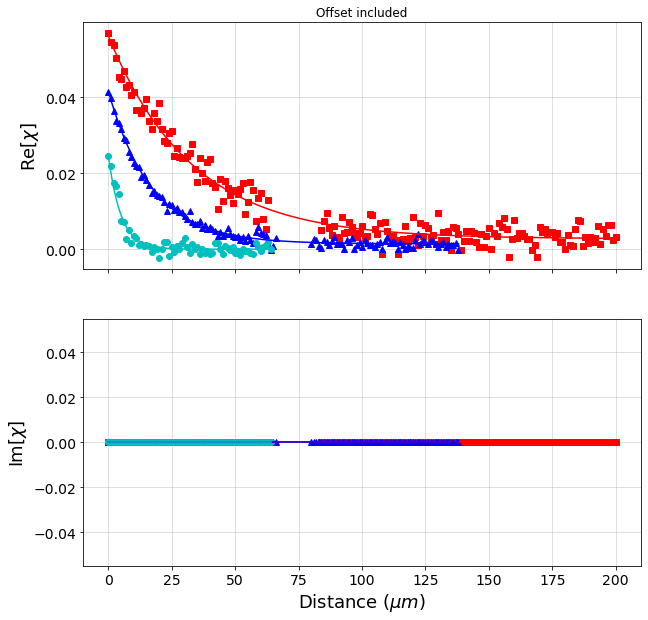

Data: 5.6791e-02 Data-base: 5.4056e-02 Amp: 5.3325e-02 Norm: 5.3325e-02 Data-base/Amp: 1.0137 Data-base/Norm: 1.0137
Data: 4.1450e-02 Data-base: 4.0057e-02 Amp: 4.0084e-02 Norm: 4.0084e-02 Data-base/Amp: 0.9993 Data-base/Norm: 0.9993
Data: 2.4415e-02 Data-base: 2.4422e-02 Amp: 2.4450e-02 Norm: 2.4450e-02 Data-base/Amp: 0.9989 Data-base/Norm: 0.9989


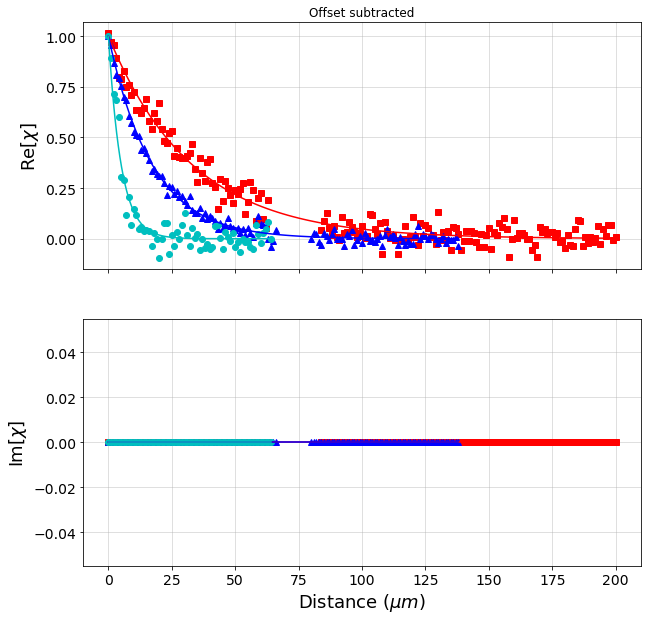

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0, 3):
    visualization.plot_chi(axes, dc_x[iy], dc_data[iy], color=colors[iy+1],
                           marker=markers[iy+1], ls='',
                           label=f'{gases[(iy+1)*3]} bar O2')
for iy in np.arange(0, 3):
    y = np.linspace(0, dc_x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(dc_out.params, iy, y, chi_dc),
                           color=colors[iy+1], marker='')
                           #label=str(frequencies[iy]) + ' Hz')
axes[0].set_title('Offset included')
plt.show()

fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0, 3):
    DC_norm = 1 / (dc_out.params[f'amp_{iy+1}']) #  + dc_out.params[f'base_{iy+1}'])
    dum = dc_data[iy][0].real
    dum_nobase = dum - dc_out.params[f'base_{iy+1}'].value
    amp = dc_out.params[f'amp_{iy+1}'].value
    print(f'Data: {dum:.4e} Data-base: {dum_nobase:.4e} Amp: {amp:.4e} Norm: {1/DC_norm:.4e} Data-base/Amp: {dum_nobase/amp:.4f}'
         f' Data-base/Norm: {dum_nobase * DC_norm:.4f}')
    visualization.plot_chi(axes, dc_x[iy], (dc_data[iy] - dc_out.params[f'base_{iy+1}']) * DC_norm, color=colors[iy+1],
                           marker=markers[iy+1], ls='',
                           label=f'{gases[(iy+1)*3]} bar O2')
for iy in np.arange(0, 3):
    DC_norm = 1 / (dc_out.params[f'amp_{iy+1}']) # + dc_out.params[f'base_{iy+1}'])
    y = np.linspace(0, dc_x[iy][-1], num=100)
    visualization.plot_chi(axes, y, (models.dataset_fun(dc_out.params, iy, y, chi_dc) - dc_out.params[f'base_{iy+1}']) * DC_norm,
                           color=colors[iy+1], marker='')
                           #label=str(frequencies[iy]) + ' Hz')
axes[0].set_title('Offset subtracted')
plt.show()

In [11]:
import itertools
ac_data = []
ac_data.append(data1[1:4])
ac_data.append(data1[5:8])
ac_data.append(data1[9:])
ac_data = list(itertools.chain.from_iterable(a for a in ac_data))

ac_x = []
ac_x.append(x[1:4])
ac_x.append(x[5:8])
ac_x.append(x[9:])
ac_x = list(itertools.chain.from_iterable(a for a in ac_x))

ac_freqs = [0.25, 1, 4, 0.25, 1, 5, 0.5, 8]

In [12]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::3]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/3)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
#     est_amp = -np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy])))
#     ac_params.add(f'amp_{iy+1}', value=-data[0].real, min=-1, max=-1e-3)
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
#     print(f'amp_{iy+1} min: {est_amp*bound_fac} max: {est_amp/bound_fac}')
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=1)
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/3)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)

## params pinned to F1
# ac_params[f'amp_2'].expr = 'amp_1'
# ac_params[f'amp_3'].expr = 'amp_1'
# ac_params[f'amp_5'].expr = 'amp_4'
# ac_params[f'amp_6'].expr = 'amp_4'
# ac_params[f'amp_8'].expr = 'amp_7'

ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_3'].expr = 'tg_1'
ac_params[f'tg_5'].expr = 'tg_4'
ac_params[f'tg_6'].expr = 'tg_4'
ac_params[f'tg_8'].expr = 'tg_7'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_3'].expr = 'gammap_1'
ac_params[f'gammap_5'].expr = 'gammap_4'
ac_params[f'gammap_6'].expr = 'gammap_4'
ac_params[f'gammap_8'].expr = 'gammap_7'

# ac_params.add(f'gammap_7', value=0.1041*2.23, vary=False)
# ac_params.add(f'gammap_8', value=0.1041*2.23, vary=False)
# ac_params.add(f'gammap_7', value=0.1041, vary=False)
# ac_params.add(f'gammap_8', value=0.1041, vary=False)
# ac_params.add(f'gammap_7', value=0, vary=False)
# ac_params.add(f'gammap_8', value=0, vary=False)
ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out.redchi)
print(fit_report(ac_out))

amp_1 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_2 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_3 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_4 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_5 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_6 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_7 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
amp_8 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174


C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Χ_red =  2.3273043291522122e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 461
    # data points      = 260
    # variables        = 14
    chi-square         = 5.7252e-05
    reduced chi-square = 2.3273e-07
    Akaike info crit   = -3957.47112
    Bayesian info crit = -3907.62158
[[Variables]]
    amp_1:    -0.01303408 +/- 2.7662e-04 (2.12%) (init = -0.01153678)
    gammap_1:  0.06809399 +/- 0.00788696 (11.58%) (init = 0.055)
    ld_1:      32.80148 (fixed)
    tg_1:      2.34478466 +/- 0.10218783 (4.36%) (init = 1)
    f_1:       0.25 (fixed)
    L_1:       0.6 (fixed)
    amp_2:    -0.01457700 +/- 3.5933e-04 (2.47%) (init = -0.01153678)
    gammap_2:  0.06809399 +/- 0.00788696 (11.58%) == 'gammap_1'
    ld_2:      32.80148 (fixed)
    tg_2:      2.34478466 +/- 0.10218783 (4.36%) == 'tg_1'
    f_2:       1 (fixed)
    L_2:       0.6 (fixed)
    amp_3:    -0.01679053 +/- 6.1471e-04 (3.66%) (init = -0.01153678)
    gammap_3:  0.06809399 +/- 0.00788696 

In [13]:
# lmfit.printfuncs.report_ci(lmfit.conf_interval(dc_mini, dc_out))

In [14]:
# lmfit.printfuncs.report_ci(lmfit.conf_interval(ac_mini, ac_out, sigmas=[1,2]))

In [83]:
# Old style options
# ac_colors = ['r', 'b', 'c']
# ac_markers = ['s', '^', 'o']
# New to avoid copyright stuff??
ac_colors = ['b', 'c', 'g']
ac_markers = ['.', '+', 'v']


ac_colors = ac_colors * 3
ac_markers = ac_markers * 3
aspect_ratio = 16 / 9 
figsize = (5, 5 / aspect_ratio )
leg_title_fontsize = 11
textsize = 11
borderpad = .2
borderaxespad = .15
columnspacing = .1
handletextpad = .1

0.25 41.44144144144144 (-2.3796355658711846e-06-0.001655051165485919j) 9.140167372215671e-07
1 17.88188188188188 (-2.1848199371177592e-05-0.00261873911304519j) 2.2802635537457362e-08
4 8.038038038038039 (-2.7959313051843923e-05-0.003089440902802581j) 1.257367088660024e-10


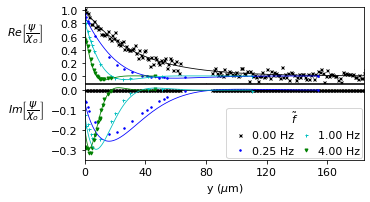

In [84]:
# 1% O2 Plots
# DC scaling
DC_ind = 0
ac_start = 0
ac_end = 3

DC_norm = 1 / dc_out.params[f'amp_{DC_ind+1}']
base = dc_out.params[f'base_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=figsize)

# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, dc_x[DC_ind], (dc_data[DC_ind] - base) * DC_norm, color='k',
                       marker='x', ms=3, ls='',
                       label='0.00 Hz')

y = np.linspace(0, dc_x[DC_ind][-1], num=300)
visualization.plot_chi(axes, y, (models.dataset_fun(dc_out.params, DC_ind, y, chi_dc) - base) * DC_norm,
                       color='k', marker='', lw=0.8)


for iy in np.arange(ac_start, ac_end):
    f_norm =  -1/ac_out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, ac_x[iy], ac_data[iy] * f_norm, color=ac_colors[iy],
                           marker=ac_markers[iy], ms=3, ls='',
                           label=f'{ac_freqs[iy]:.2f} Hz')
zeros1 = []
for iy in np.arange(ac_start, ac_end):
    f_norm = -1 / ac_out.params[f'amp_{iy+1}']
    y = np.linspace(0, ac_x[iy][-1], num=300)
    visualization.plot_chi(axes, y, models.dataset_fun(ac_out.params, iy, y, models.chi_patterned) * f_norm,
                           color=ac_colors[iy], marker='', lw=0.8, fontsize=textsize)
    # Detecting zero-crossing points
    y = np.linspace(0, x[iy][-1], num=1000)
    dum = models.dataset_fun(ac_out.params, iy, y, models.chi_patterned)
    chi_cross = dum[np.sign(dum) == -1][0]
    y_cross = y[np.sign(dum) == -1][0]
    zeros1.append(y_cross)
    print(ac_out.params[f'f_{iy+1}'].value, y_cross, chi_cross, np.min(np.abs(dum)))


for ax in axes:
    ax.set_xlim(-0, int(ac_x[ac_start][-1] * 1.2))
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.grid(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(40))
# axes[0].set_ylim(-0.0015, 0.014)
# axes[1].set_ylim(-.006, 0.0005)
axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_ylim(-.1, 1.05)
axes[1].set_ylim(-.35, .03)
# axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.004))

axes[0].set_ylabel(r'$Re\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=35)
axes[1].set_ylabel(r'$Im\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=25)
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$', ncol=2,
           title_fontsize=leg_title_fontsize,
           fontsize=textsize,
           borderpad=borderpad,
           borderaxespad=borderaxespad,
           columnspacing=columnspacing,
           handletextpad=handletextpad)

plt.savefig(r'Plots\\Profiles\\1%O2_3.svg', dpi=400, bbox_inches='tight')
plt.show()

0.25 41.25725725725726 (-2.976181232996702e-07-0.0006184686351912353j) 0.0004460619830686588
1 15.60960960960961 (-1.4520760685728779e-05-0.0016739056799731412j) 2.5828803674910126e-09
5 5.918918918918919 (-1.5823354682748707e-05-0.0017836219266636221j) 6.239259187398405e-11


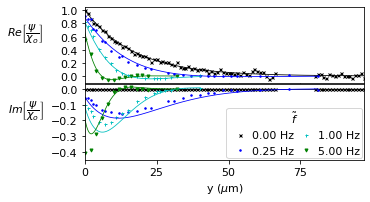

In [85]:
# 10% O2 Plots
# DC scaling
DC_ind = 1
ac_start = 3
ac_end = 6


DC_norm = 1 / dc_out.params[f'amp_{DC_ind+1}']
base = dc_out.params[f'base_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=figsize)

# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, dc_x[DC_ind], (dc_data[DC_ind] - base) * DC_norm, color='k',
                       marker='x', ms=3, ls='',
                       label='0.00 Hz')

y = np.linspace(0, dc_x[DC_ind][-1], num=300)
visualization.plot_chi(axes, y, (models.dataset_fun(dc_out.params, DC_ind, y, chi_dc) - base) * DC_norm,
                       color='k', marker='', lw=0.8)


for iy in np.arange(ac_start, ac_end):
    f_norm =  -1/ac_out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, ac_x[iy], ac_data[iy] * f_norm, color=ac_colors[iy],
                           marker=ac_markers[iy], ms=3, ls='',
                           label=f'{ac_freqs[iy]:.2f} Hz')
zeros1 = []
for iy in np.arange(ac_start, ac_end):
    f_norm = -1 / ac_out.params[f'amp_{iy+1}']
    y = np.linspace(0, ac_x[iy][-1], num=300)
    visualization.plot_chi(axes, y, models.dataset_fun(ac_out.params, iy, y, models.chi_patterned) * f_norm,
                           color=ac_colors[iy], marker='', lw=0.8, fontsize=textsize)
    # Detecting zero-crossing points
    y = np.linspace(0, x[iy][-1], num=1000)
    dum = models.dataset_fun(ac_out.params, iy, y, models.chi_patterned)
    chi_cross = dum[np.sign(dum) == -1][0]
    y_cross = y[np.sign(dum) == -1][0]
    zeros1.append(y_cross)
    print(ac_out.params[f'f_{iy+1}'].value, y_cross, chi_cross, np.min(np.abs(dum)))


for ax in axes:
    ax.set_xlim(0, int(ac_x[ac_start][-1] * 1.2))
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.grid(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
# axes[0].set_ylim(-0.0015, 0.014)
# axes[1].set_ylim(-.006, 0.0005)
axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_ylim(-.1, 1.05)
axes[1].set_ylim(-.45, .03)
# axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.004))

axes[0].set_ylabel(r'$Re\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=35)
axes[1].set_ylabel(r'$Im\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=25)
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$', ncol=2,
           title_fontsize=leg_title_fontsize,
           fontsize=textsize,
           borderpad=borderpad,
           borderaxespad=borderaxespad,
           columnspacing=columnspacing,
           handletextpad=handletextpad)

plt.savefig(r'Plots\\Profiles\\10%O2_4.svg', dpi=400, bbox_inches='tight')
plt.show()

0.5 34.71471471471472 (-2.6857669880204165e-09-4.57257794907704e-06j) 1.5423026494795373e-06
8 3.6196196196196198 (-3.310689379179793e-06-0.0010483516451486705j) 9.871066576341902e-09


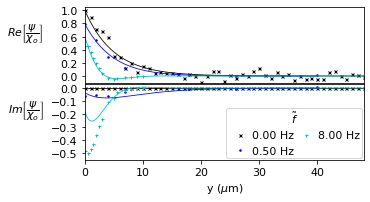

In [86]:
# 100% O2 Plots
# DC scaling
DC_ind = 2
ac_start = 6
ac_end = 8


DC_norm = 1 / dc_out.params[f'amp_{DC_ind+1}']
base = dc_out.params[f'base_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=figsize)#2.28, 3.90))

# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, dc_x[DC_ind], (dc_data[DC_ind] - base) * DC_norm, color='k',
                       marker='x', ms=3, ls='',
                       label='0.00 Hz')

y = np.linspace(0, dc_x[DC_ind][-1], num=300)
visualization.plot_chi(axes, y, (models.dataset_fun(dc_out.params, DC_ind, y, chi_dc) - base) * DC_norm,
                       color='k', marker='', lw=0.8)


for iy in np.arange(ac_start, ac_end):
    f_norm =  -1/ac_out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, ac_x[iy], ac_data[iy] * f_norm, color=ac_colors[iy],
                           marker=ac_markers[iy], ms=3, ls='',
                           label=f'{ac_freqs[iy]:.2f} Hz')
zeros1 = []
for iy in np.arange(ac_start, ac_end):
    f_norm = -1 / ac_out.params[f'amp_{iy+1}']
    y = np.linspace(0, ac_x[iy][-1], num=300)
    visualization.plot_chi(axes, y, models.dataset_fun(ac_out.params, iy, y, models.chi_patterned) * f_norm,
                           color=ac_colors[iy], marker='', lw=0.8, fontsize=textsize)
    # Detecting zero-crossing points
    y = np.linspace(0, x[iy][-1], num=1000)
    dum = models.dataset_fun(ac_out.params, iy, y, models.chi_patterned)
    chi_cross = dum[np.sign(dum) == -1][0]
    y_cross = y[np.sign(dum) == -1][0]
    zeros1.append(y_cross)
    print(ac_out.params[f'f_{iy+1}'].value, y_cross, chi_cross, np.min(np.abs(dum)))


for ax in axes:
    ax.set_xlim(-0, int(ac_x[ac_start][-1] * 1.2))
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.grid(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
# axes[0].set_ylim(-0.0015, 0.014)
# axes[1].set_ylim(-.006, 0.0005)
axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_ylim(-.1, 1.05)
axes[1].set_ylim(-.55, .03)
# axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.004))

axes[0].set_ylabel(r'$Re\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=35)
axes[1].set_ylabel(r'$Im\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=25)
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$', ncol=2,
           title_fontsize=leg_title_fontsize,
           fontsize=textsize,
           borderpad=borderpad,
           borderaxespad=borderaxespad,
           columnspacing=columnspacing,
           handletextpad=handletextpad)

plt.savefig(r'Plots\\Profiles\\100%O2_3.svg', dpi=400, bbox_inches='tight')
plt.show()

In [1]:
def calc_Dv(ld=1, tg=1, Ao=1):
    """Calculate vacancy diffusion coefficient.

    Parameters
    ----------
    ld : float
        Utilization length in microns
    tg : float
        Gerischer time constant in seconds
    Ao : float
        Thermodynamic factor; unitless.

    Returns
    -------
    dv : float
        Diffusion coefficient in units cm^2/s."""

    ld = ld * 1e-4
    dv = ld ** 2 / (Ao * tg)

    return dv


def calc_Roo(tg=1, Ao=1, xvo=.01, L=0.630):
    """Calculate exchange rate coefficient.

    Parameters
    ----------
    tg : float
        Gerischer time constant in seconds
    Ao : float
        Thermodynamic factor; unitless.
    xvo : float
        Vacancy mol fraction
    L : float
        Film thickness in microns.

    Returns
    -------
    roo : float
        Exchange rate coefficient in units mol cm^-2 s^-1."""

    L = L * 1e-4
    co = 3 / 33.7
    roo = co * L * xvo / (4 * tg * Ao)

    return roo

In [5]:
calc_Dv(ld=4.98, tg=0.145, Ao=1.67)

1.024175098079703e-06

In [6]:
calc_Roo(tg=2.344, Ao=2.689, xvo=2.008e-2)
calc_Roo(tg=2.344, Ao=2.689, xvo=2.008e-2)
calc_Roo(tg=2.344, Ao=2.689, xvo=2.008e-2)

4.4667043838716345e-09

In [148]:
Aos = [2.6894, 2.6894, 2.6894, 2.0881, 2.0881, 2.0881, 1.6732, 1.6732]
xvos = [0.020081, 0.020081, 0.020081, 0.013103, 0.013103, 0.013103, 0.007532, 0.007532]
for iy, _ in enumerate(ac_data):
    ld = ac_out.params[f'ld_{iy+1}'].value
    tg = ac_out.params[f'tg_{iy+1}'].value
    
    dv = calc_Dv(ld=ld,tg=tg,Ao=Aos[iy])
    roo = calc_Roo(tg=tg, Ao=Aos[iy], xvo=xvos[iy])
    print(f'Dv = {dv:.3e} cm^2/s Roo = {roo:.3e} mol / cm^2 / s')

Dv = 1.706e-06 cm^2/s Roo = 4.465e-09 mol / cm^2 / s
Dv = 1.706e-06 cm^2/s Roo = 4.465e-09 mol / cm^2 / s
Dv = 1.706e-06 cm^2/s Roo = 4.465e-09 mol / cm^2 / s
Dv = 1.488e-06 cm^2/s Roo = 9.299e-09 mol / cm^2 / s
Dv = 1.488e-06 cm^2/s Roo = 9.299e-09 mol / cm^2 / s
Dv = 1.488e-06 cm^2/s Roo = 9.299e-09 mol / cm^2 / s
Dv = 9.764e-07 cm^2/s Roo = 4.160e-08 mol / cm^2 / s
Dv = 9.764e-07 cm^2/s Roo = 4.160e-08 mol / cm^2 / s


# Old/Scratch

In [113]:
9.6e-7/1.5e-6

0.6399999999999999

In [114]:
1.19e-6/1.5e-6

0.7933333333333333

In [97]:
1.7e-6/1.5e-6

1.1333333333333333

0.25 39.61761761761762 (-2.6984231612456615e-06-0.001889561541311586j) 9.862223817044184e-06
1 17.61761761761762 (-2.163851760026992e-05-0.0026816364174242382j) 9.99608854075387e-07
4 7.9659659659659665 (-1.0565887802240284e-05-0.0031100817385245846j) 5.2581993139794855e-06


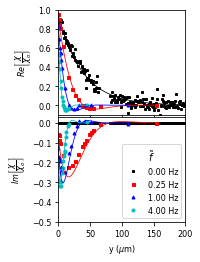

In [121]:
# DC scaling
DC_ind = 0
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

norm = out.params[f'amp_{DC_ind+2}'] / out.params[f'amp_{DC_ind+1}']
DC_norm = -1 / out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(2.28, 3.90))

# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind] * DC_norm, color=colors[0],
                       marker=markers[0], ms=3, ls='',
                       label=f'{frequencies[0]:.2f} Hz')

y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned) * DC_norm,
                       color=colors[0], marker='', lw=0.8)

zeros1 = []
for iy in np.arange(1,sizes[0]):
    f_norm = -1 / out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, x[iy], data1[iy] * f_norm, color=colors[iy],
                           marker=markers[iy], ms=3, ls='',
                           label=f'{frequencies[iy]:.2f} Hz')
    y = np.linspace(0, x[iy][-1], num=1000)
    dum = models.dataset_fun(out.params, iy, y, models.chi_patterned)
    chi_cross = dum[np.sign(dum) == -1][0]
    y_cross = y[np.sign(dum) == -1][0]
    zeros1.append(y_cross)
    print(out.params[f'f_{iy+1}'].value, y_cross, chi_cross, np.min(np.abs(dum)))

axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_xlim(0, 200)
axes[1].set_xlim(0, 200)
axes[0].tick_params(axis='both', which='major', labelsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=8)
# axes[0].set_ylim(-0.0015, 0.014)
# axes[1].set_ylim(-.006, 0.0005)
axes[0].set_ylim(-.1, 1)
axes[1].set_ylim(-.5, .03)
# axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.004))
axes[0].grid(False)
axes[1].grid(False)

axes[0].set_ylabel(r'$Re\left[\dfrac{\chi}{\chi_o}\right]$')
axes[1].set_ylabel(r'$Im\left[\dfrac{\chi}{\chi_o}\right]$')
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$', fontsize=textsize)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Profiles\\1%O2_8.svg', dpi=400, bbox_inches='tight')

0.25 38.91891891891892 (-1.4543188572182811e-06-0.0008045803408189879j) 5.033617151824501e-05
1 15.255255255255255 (-7.176198742892275e-07-0.0017577047652577783j) 0.00011994414982764605
5 5.893893893893894 (-2.2593912658965334e-06-0.0017780484109591406j) 4.423890431115578e-06


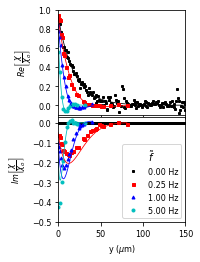

In [122]:
# DC scaling
DC_ind = sizes[0]
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

norm = out.params[f'amp_{DC_ind+2}'] / out.params[f'amp_{DC_ind+1}']
DC_norm = -1 / out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(2.28, 3.90))

# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind] * DC_norm, color=colors[0],
                       marker=markers[0], ms=3, ls='',
                       label=f'{frequencies[0]:.2f} Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned) * DC_norm,
                       color=colors[0], marker='', lw=0.8)

for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    f_norm = -1 / out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, x[iy], data1[iy] * f_norm, color=colors[iy],
                           marker=markers[iy], ms=3,  ls='',
                           label=f'{frequencies[iy]:.2f} Hz')

zeros10 = []
for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    y = np.linspace(0, x[iy][-1], num=100)
    f_norm = -1 / out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, models.chi_patterned) * f_norm,
                           color=colors[iy], marker='', lw=0.8, fontsize=textsize)
                           #label=str(frequencies[iy]) + ' Hz Fit')
    y = np.linspace(0, x[iy][-1], num=1000)
    dum = models.dataset_fun(out.params, iy, y, models.chi_patterned)
    chi_cross = dum[np.sign(dum) == -1][0]
    y_cross = y[np.sign(dum) == -1][0]
    zeros10.append(y_cross)
    print(out.params[f'f_{iy+1}'].value, y_cross, chi_cross, np.min(np.abs(dum)))

axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_xlim(0, 150)
axes[1].set_xlim(0, 150)
axes[0].tick_params(axis='both', which='major', labelsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=8)
# axes[0].set_ylim(-0.001, 0.0115)
# axes[1].set_ylim(-.006, 0.0005)
axes[0].set_ylim(-.1, 1)
axes[1].set_ylim(-.5, .03)

axes[0].grid(False)
axes[1].grid(False)

axes[0].set_ylabel(r'$Re\left[\dfrac{\chi}{\chi_o}\right]$')
axes[1].set_ylabel(r'$Im\left[\dfrac{\chi}{\chi_o}\right]$')
# axes[0].set_title('10% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$', fontsize=textsize)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Profiles\\10%O2_6.svg', dpi=400, bbox_inches='tight')

0.5 32.46346346346346 (-1.6010086704514774e-09-9.568065211691752e-06j) 1.7306691207027996e-06
8 3.6061061061061057 (-4.77153715667557e-06-0.0013590097267264655j) 1.0215590134731644e-14


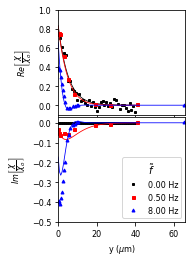

In [123]:
# DC scaling
DC_ind = sum(sizes[:2])
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

norm = out.params[f'amp_{DC_ind+2}'] / out.params[f'amp_{DC_ind+1}']
DC_norm = -1 / out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(2.28, 3.90))


# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind] * DC_norm, color=colors[0],
                       marker=markers[0], ms=3, ls='',
                       label=f'{frequencies[0]:.2f} Hz')
y = np.linspace(0, x[DC_ind][-1], num=300)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned) * DC_norm,
                       color=colors[0], marker='', lw=0.8)


for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    f_norm = -1 / out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, x[iy], data1[iy] * f_norm, color=colors[iy],
                           marker=markers[iy], ms=3, ls='', 
                           label=f'{frequencies[iy]:.2f} Hz')

zeros100 = []
for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    f_norm = -1 / out.params[f'amp_{iy+1}']
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, models.chi_patterned) * f_norm,
                           color=colors[iy], marker='', lw=0.8, fontsize=textsize)
                           #label=str(frequencies[iy]) + ' Hz Fit')
    y = np.linspace(0, x[iy][-1], num=1000)
    dum = models.dataset_fun(out.params, iy, y, models.chi_patterned)
    chi_cross = dum[np.sign(dum) == -1][0]
    y_cross = y[np.sign(dum) == -1][0]
    zeros100.append(y_cross)
    print(out.params[f'f_{iy+1}'].value, y_cross, chi_cross, np.min(np.abs(dum)))        

axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_xlim(0, 66)
axes[1].set_xlim(0, 66)
axes[0].tick_params(axis='both', which='major', labelsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=8)
# axes[0].set_ylim(-0.0019, 0.0165)
# axes[1].set_ylim(-.006, 0.0005)
axes[0].set_ylim(-.1, 1)
axes[1].set_ylim(-.5, .03)

axes[0].grid(False)
axes[1].grid(False)

axes[0].set_ylabel(r'$Re\left[\dfrac{\chi}{\chi_o}\right]$')
axes[1].set_ylabel(r'$Im\left[\dfrac{\chi}{\chi_o}\right]$')
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$', fontsize=textsize)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Profiles\\100%O2_5.svg', dpi=400, bbox_inches='tight')